In [669]:
# Loading required packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [1319]:
# After downloading files from Kaggle source, https://www.kaggle.com/datasets/tunguz/movietweetings/data?select=movies.dat
# Convert to csv then read as follows

Twitter_ratings = pd.read_csv('ratings.csv',sep = "::",skipinitialspace = True, header = None)
Twitter_movies = pd.read_csv('movies.csv', sep = "::",skipinitialspace = True, header = None)

/var/folders/sq/hskpm88j701ghk9f50_gb25r0000gn/T/ipykernel_94869/3157890407.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  Twitter_ratings = pd.read_csv('ratings.csv',sep = "::",skipinitialspace = True, header = None)
/var/folders/sq/hskpm88j701ghk9f50_gb25r0000gn/T/ipykernel_94869/3157890407.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  Twitter_movies = pd.read_csv('movies.csv', sep = "::",skipinitialspace = True, header = None)


### The following cells are the code for Section 2.2

In [1321]:

#Getting the columns right

Twitter_ratings.columns = ['user_id','movie_id','rating','rating_timestamp']
Twitter_movies.columns = ['movie_id','movie title (movie year)','genre']

Twitter_movies = Twitter_movies[['movie_id','movie title (movie year)']] # selecting only revelant columns
Twitter_ratings = Twitter_ratings[['movie_id','rating']]



In [1323]:
# the goal is to now aggregate an average rating for all ratings with the same movie_id - for the Twitter_ratings dataset

# can do this using simply using group_by function in pandas

Aggregated_ratings = Twitter_ratings.groupby(['movie_id']).mean()

# Now we need to match the movie_id with aggregated ratings. At this step, it is easier to work with numpy arrays

In [1331]:
# Better to work with numpy arrays for this task, as its easier to work with

movie_id = list(Aggregated_ratings.index.to_numpy())
movie_ratings = list(Aggregated_ratings.values)

tuple_ratings = []

# getting movie_id and movie_ratings as tuples are easier to work with

for i in range(len(movie_id)):
    tuple_ratings.append((movie_id[i],movie_ratings[i][0]))

movie_id_movs = list(Twitter_movies['movie_id'])
movie_ratings_movs = list(Twitter_movies['movie title (movie year)'])


tuple_ratings_movs = []

for i in range(len(movie_id_movs)):
    tuple_ratings_movs.append((movie_id_movs[i],movie_ratings_movs[i]))

# removing duplicates

for i in tuple_ratings_movs:
    if tuple_ratings_movs.count(i) > 1:
        tuple_ratings_movs.remove(i)
        
# Now searching through both files, matching movie_id's and then concatenating results
# It does take some time, but this step is necessary as by inspection the movie_id list is not the same on both tuple lists

final_ratings = []

for i in range(len(tuple_ratings)):
    for j in range(len(tuple_ratings_movs)):
        if tuple_ratings[i][0] == tuple_ratings_movs[j][0]: # movie_id match
            final_ratings.append((tuple_ratings_movs[j][0],tuple_ratings_movs[j][1],tuple_ratings[i][1]))

In [1383]:
# Even after previous steps there are still some duplicate names in films, these should also be removed, 
final_ratings_nd = []

for i in range(len(final_ratings)):
    final_ratings_nd.append(final_ratings[i])
    match = False # whether or not i need be removed
    for j in range(len(final_ratings)):
        if i != j:
            if final_ratings[i][1] == final_ratings[j][1]:
                match = True

    if match:
        final_ratings_nd.remove(final_ratings[i])
        

In [1454]:
# The Year value is quite good and can be used to complement the IMDB dataset in R, but it should be a new entry, not in the movie name column

final_ratings_new = []

for i in final_ratings_nd:
    v = i[1] # movie name (year) value
    index = v.find('(') # where the date starts
    name = v[0:index-1] # removing space
    year = v[index+1:index+5] # 4 characters makes year
    final_ratings_new.append((i[0],name,year,i[2]))


In [1594]:
# movie_id is no longer necessary now

final_ratings_noid = []

for i in final_ratings_new:
    final_ratings_noid.append((i[1],i[2]))



[('Edison Kinetoscopic Record of a Sneeze', '1894'),
 ('La sortie des usines Lumière', '1895'),
 ('The Arrival of a Train', '1896'),
 ('The Oxford and Cambridge University Boat Race', '1895'),
 ('Le manoir du diable', '1896'),
 ('Une nuit terrible', '1896'),
 ('A Trip to the Moon', '1902'),
 ('The Great Train Robbery', '1903'),
 ('Hiawatha, the Messiah of the Ojibway', '1903'),
 ('The Adventures of Dollie', '1908'),
 ('The Country Doctor', '1909'),
 ('Frankenstein', '1910'),
 ('The Lonedale Operator', '1911'),
 ('Cleopatra', '1912'),
 ("L'inferno", '1911'),
 ('Max et Jane veulent faire du théâtre', '1911'),
 ("Fantômas - À l'ombre de la guillotine", '1913'),
 ('Cabiria', '1914'),
 ('Dough and Dynamite', '1914'),
 ('His Majesty, the Scarecrow of Oz', '1914'),
 ('His Musical Career', '1914'),
 ('His New Profession', '1914'),
 ('Laughing Gas', '1914'),
 ('The New Janitor', '1914'),
 ('The Ocean Waif', '1916'),
 ('The Patchwork Girl of Oz', '1914'),
 ('Recreation', '1914'),
 ('The Rounders

In [1580]:
# Now turn final_ratings_new to a data frame and save to a csv file. movie_id is not needed so is removed

Twitter_Ratings = pd.DataFrame(final_ratings_new)

Twitter_Ratings = Twitter_Ratings[[1,2,3]]
Twitter_Ratings.columns = ['movie_name','year','twitter_rating']

# Now secondary goal is to match this with the IMDB dataset, note IMDB_cleaned is output of section 2.1 of the R code

IMDB = pd.read_csv('IMDB_cleaned.csv')
IMDB


,names,revenue,score,orig_lang,crew,budget,year
0,Creed III,2.716167e+08,73,English,"Michael B. Jordan, Adonis Creed, Tessa Thompso...",75000000.0,2023
1,Avatar: The Way of Water,2.316795e+09,78,English,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",460000000.0,2022
2,The Super Mario Bros. Movie,7.244590e+08,76,English,"Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",100000000.0,2023
3,Mummies,3.420000e+07,70,"Spanish, Castilian","Óscar Barberán, Thut (voice), Ana Esther Albor...",12300000.0,2023
4,Supercell,3.409420e+08,61,English,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",77000000.0,2023
...,...,...,...,...,...,...,...
10173,20th Century Women,9.353729e+06,73,English,"Annette Bening, Dorothea Fields, Lucas Jade Zu...",7000000.0,2016
10174,Delta Force 2: The Colombian Connection,6.698361e+06,54,English,"Chuck Norris, Col. Scott McCoy, Billy Drago, R...",9145817.8,1990
10175,The Russia House,2.299799e+07,61,English,"Sean Connery, Bartholomew 'Barley' Scott Blair...",21800000.0,1990
10176,Darkman II: The Return of Durant,4.756613e+08,55,English,"Larry Drake, Robert G. Durant, Arnold Vosloo, ...",116000000.0,1995


In [1584]:
# Now we need to get the necessary columns of the IMDB dataset and match it with the Twitter Rattings movie column

Twitter = Twitter_Ratings[['movie_name','year']]
IMDB = IMDB[['names','year']]

Twitter_movies = list(Twitter[['movie_name']].to_numpy())
IMDB_movies = list(IMDB[['names']].to_numpy())

Twitter_years = list(Twitter[['year']].to_numpy())
IMDB_years = list(IMDB[['year']].to_numpy())

In [1598]:

# Now search for a match, do a similar approach, this time making a tuple of a movie in the IMDB movies set, then appending rating as it appears in the Twitter set
final_matches = []

for i in range(len(IMDB_movies)):
    for j in range(len(Twitter_movies)):
        if (IMDB_movies[i][0] == Twitter_movies[j][0]) and (int(IMDB_years[i][0]) == int(Twitter_years[j][0])):
            final_matches.append((IMDB_movies[i][0],Twitter_Ratings[Twitter_Ratings['movie_name'] == IMDB_movies[i][0]]))
            

    

In [1600]:
len(final_matches)/len(IMDB_movies) # quite a narrow match, but this is to be expected, and the missing values need to be dealt with. As of now just the average will be used



0.41481627038710944

In [1630]:
# Only extracting the twitter rating

IMDB_Movies = []

for i in final_matches:
    IMDB_Movies.append((i[0],i[1].iloc[0,1],i[1].iloc[0,2]))

In [1634]:
count = 0
for i in IMDB_Movies:
    if IMDB_Movies.count(i) > 1:
        count += 1

count # Even after the data extraction process there are still some leaks, they must sill be removed

count = 0
for i in IMDB_Movies:
    if IMDB_Movies.count(i) > 1:
        IMDB_Movies.remove(i)


In [1644]:
len(IMDB_Movies) # There are now only 4034 usable data sets left, down from a total of almost 10000. Nonetheless, as social media data is centreal to the research question, these are the only movies that can be used

IMDB_Movies


[('The Passion of the Christ', '2004', 8.356164383561644),
 ('John Wick: Chapter 2', '2017', 7.545563549160671),
 ('John Wick: Chapter 3 - Parabellum', '2019', 7.404006677796327),
 ('Avatar', '2009', 8.203980099502488),
 ('John Wick', '2014', 7.107445008460237),
 ('Super Mario Bros.', '1993', 6.125),
 ('Shazam!', '2019', 7.4068554396423245),
 ('Avengers: Infinity War', '2018', 8.763826606875934),
 ('Creed II', '2018', 7.316265060240964),
 ('Creed', '2015', 7.887662988966901),
 ('Wrath of Man', '2021', 7.361256544502618),
 ('Hacksaw Ridge', '2016', 8.715289982425308),
 ('Life in a Year', '2020', 6.25),
 ('The Chronicles of Narnia: The Lion, the Witch and the Wardrobe',
  '2005',
  8.023809523809524),
 ('Shrek', '2001', 8.545454545454545),
 ('Murder Mystery', '2019', 6.108910891089109),
 ('Harry Potter and the Chamber of Secrets', '2002', 7.84549356223176),
 ('Cars 3', '2017', 7.170940170940171),
 ('Interstellar', '2014', 8.842265943012212),
 ('Coraline', '2009', 7.809523809523809),
 ('H

In [1764]:
IMDB = pd.read_csv('IMDB_cleaned.csv')
IMDB

# Now comes the difficult process of now restricting the dataset to the values of the IMDB dataset to that shown in the IMDB_Movies list
final_tuple_list = []

for i in IMDB_Movies:
    new = IMDB[(IMDB['names'] == i[0]) & (IMDB['year'] == int(i[1]))] # restricting to the correct row
    new = new.to_numpy() # converting to numpy for easy indexation

    if np.shape(new) == (1,7):
        final_tuple_list.append((new[0,0],new[0,1],new[0,2],new[0,3],new[0,4],new[0,5],i[2]))

In [1774]:
len(final_tuple_list) # slightly more data lost, only 3674 rows remain

IMDB_final = pd.DataFrame(final_tuple_list)
IMDB_final.columns = ['name','revenue','imdb_score','orig_lang','crew','budget','twitter_score']



## Section 2.3 Actor-Twitter-IMDB (ATI) Dataset

In [1798]:
import numpy as np

crew_array = np.array(IMDB_final[["crew"]])

cast = list()

for i in crew_array:
    cast.append(i[0])

In [1816]:
top_cast = pd.read_csv('top_actors.csv')
top_cast

,Row,Actor,Total Box Office,# Films,Average Box Office,Unnamed: 5,Unnamed: 6
0,1.0,Samuel L. Jackson,"$5,850,170,559",71.0,"$82,396,768",NaN,NaN
1,2.0,"Robert Downey, Jr.","$5,474,546,165",45.0,"$121,656,581",NaN,NaN
2,3.0,Chris Pratt,"$5,354,329,237",26.0,"$205,935,740",NaN,NaN
3,4.0,Scarlett Johansson,"$5,337,686,916",36.0,"$148,269,081",NaN,NaN
4,5.0,Tom Hanks,"$5,196,590,628",58.0,"$89,596,390",NaN,NaN
...,...,...,...,...,...,...,...
695,NaN,NaN,NaN,NaN,NaN,NaN,NaN
696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
697,NaN,NaN,NaN,NaN,NaN,NaN,NaN
698,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1820]:
# turning it into a tuples list. Easier to work with 

top_cast_act = np.array(top_cast[["Actor"]])
top_cast_box = np.array(top_cast[["Total Box Office"]])

tuple_list = []

for i in range(100):
    tuple_list.append((top_cast_act[i][0],top_cast_box[i][0]))

In [1822]:
tuple_list # for reference to see the progress

[('Samuel L. Jackson', '$5,850,170,559 '),
 ('Robert Downey, Jr.', '$5,474,546,165 '),
 ('Chris Pratt', '$5,354,329,237 '),
 ('Scarlett Johansson', '$5,337,686,916 '),
 ('Tom Hanks', '$5,196,590,628 '),
 ('Zoe Saldana', '$5,076,371,324 '),
 ('Tom Cruise', '$5,039,111,884 '),
 ('Bradley Cooper', '$4,768,433,722 '),
 ('Harrison Ford', '$4,433,993,888 '),
 ('Chris Hemsworth', '$4,429,513,459 '),
 ('Chris Evans', '$4,216,429,266 '),
 ('Dwayne Johnson', '$4,191,515,313 '),
 ('Vin Diesel', '$3,962,558,107 '),
 ('Will Smith', '$3,735,127,227 '),
 ('Johnny Depp', '$3,685,235,615 '),
 ('Steve Carell', '$3,596,657,724 '),
 ('Eddie Murphy', '$3,582,380,113 '),
 ('Tom Holland', '$3,495,258,749 '),
 ('Mark Ruffalo', '$3,417,565,032 '),
 ('Matt Damon', '$3,390,763,036 '),
 ('Don Cheadle', '$3,257,133,326 '),
 ('Dave Bautista', '$3,208,150,933 '),
 ('Jack Black', '$3,206,612,703 '),
 ('Jeremy Renner', '$3,185,916,086 '),
 ('Hugh Jackman', '$3,160,763,815 '),
 ('Jim Carrey', '$3,154,505,239 '),
 ('Kar

In [1824]:
# making the tuple of top-box office have numeric money values

tuple_list_new = []

for i in tuple_list:
    str = list(i[1])
    for j in str:
        if j == ' ':
            str.remove(j)
        if j == ',':
            str.remove(j)
        if j == '$':
            str.remove(j)
    str = "".join(str)
    tuple_list_new.append((i[0],float(str)))

In [1850]:
top_box_office_stars = []

# iterating the crew values, seeing which actors appear in the top 100 actors list

for i in cast:
    sum = 0
    if type(i) == type('string'):
        for j in i.split(', '):
            for k in tuple_list_new:
                if j == k[0]:
                    sum = sum + k[1]
        top_box_office_stars.append(sum)
    else:
        top_box_office_stars.append(-10000000)

# now have the aligned 'top_box_office_stars'. simply append now to IMDB_final

IMDB_final['actors_score'] = np.array(top_box_office_stars)
IMDB_final = IMDB_final[['revenue','imdb_score','orig_lang','budget','twitter_score','actors_score']]
IMDB_final

,revenue,imdb_score,orig_lang,budget,twitter_score,actors_score
0,6.223136e+08,74,English,25000000.0,8.356164,0.000000e+00
1,1.715399e+08,73,English,40000000.0,7.545564,2.524626e+09
2,3.267097e+08,74,English,55000000.0,7.404007,2.524626e+09
3,2.923706e+09,76,English,237000000.0,8.203980,1.906604e+09
4,7.595880e+07,74,English,30000000.0,7.107445,2.524626e+09
...,...,...,...,...,...,...
3669,7.060021e+08,76,Japanese,62600000.0,8.300000,0.000000e+00
3670,5.637564e+08,75,English,132000000.0,7.870968,0.000000e+00
3671,9.353729e+06,73,English,7000000.0,7.352000,0.000000e+00
3672,6.698361e+06,54,English,9145817.8,5.500000,0.000000e+00


In [1892]:
# finish off and write to csv dataset. This is the final-cleaned ATI dataset

IMDB_final.to_csv('ATI.csv')



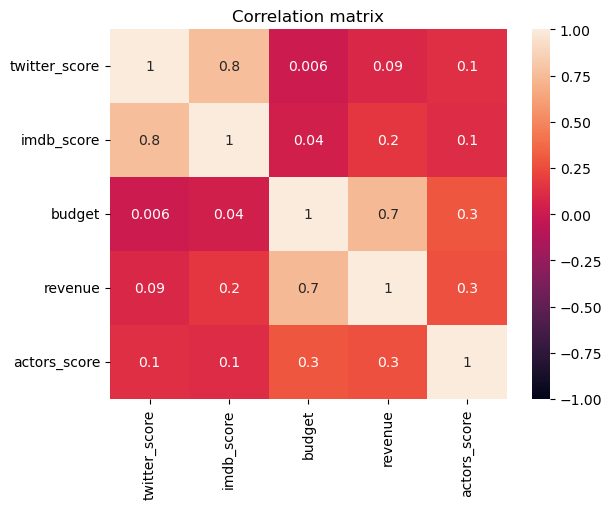

In [1896]:
ATI_final = pd.read_csv('ATI.csv')

data = ATI_final[['twitter_score','imdb_score','budget','revenue','actors_score']]
corr = data.corr()
#matrix = np.triu(corr)
sns.heatmap(corr, vmax=1.0, vmin=-1.0, fmt='.1g', annot=True)

plt.title('Correlation matrix')
plt.show()